In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip uninstall tensorflow
!pip install tensorflow==2.14.0
!pip install tensorflow_addons

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
  

In [3]:
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa

generator_rj = load_model('/content/drive/MyDrive/my_keras_model.h5')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
import tensorflow as tf
print(tf.__version__)

2.14.0


In [5]:
generator_gaussian = load_model('/content/drive/MyDrive/gaussian_noise(108).h5')

In [6]:
generator_no_noise = load_model('/content/drive/MyDrive/no_noise.h5')

In [7]:
image_segmentor = load_model('/content/drive/MyDrive/trained_segnet_model.keras')

In [8]:
!unzip /content/drive/'MyDrive'/portrait256 -d portrait256
%rm -rf 'portrait256/__MACOSX'

Streaming output truncated to the last 5000 lines.
  inflating: portrait256/portrait256/masks/msk/warm_01587.png  
  inflating: portrait256/__MACOSX/portrait256/masks/msk/._warm_01587.png  
  inflating: portrait256/portrait256/masks/msk/warm_00841.png  
  inflating: portrait256/__MACOSX/portrait256/masks/msk/._warm_00841.png  
  inflating: portrait256/portrait256/masks/msk/syn_00901.png  
  inflating: portrait256/__MACOSX/portrait256/masks/msk/._syn_00901.png  
  inflating: portrait256/portrait256/masks/msk/01030.png  
  inflating: portrait256/__MACOSX/portrait256/masks/msk/._01030.png  
  inflating: portrait256/portrait256/masks/msk/warm_syn_test_00167.png  
  inflating: portrait256/__MACOSX/portrait256/masks/msk/._warm_syn_test_00167.png  
  inflating: portrait256/portrait256/masks/msk/warm_beautiful-cute-dress-eyes-41537.png  
  inflating: portrait256/__MACOSX/portrait256/masks/msk/._warm_beautiful-cute-dress-eyes-41537.png  
  inflating: portrait256/portrait256/masks/msk/warm_00869

In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def load_image(path):
    img=cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [10]:
import os

directory = 'portrait256'
image_files = []
mask_files = []
for subdir, _, files in os.walk(directory):
    if subdir.endswith("img"):
        image_files.extend([os.path.join(subdir, f) for f in files])
        image_files.sort()
    elif subdir.endswith("msk"):
        mask_files.extend([os.path.join(subdir, f) for f in files])
        mask_files.sort()

In [11]:
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def denormalize(image):
  image = (image + 1) * 127.5
  image = tf.cast(image, tf.uint8)
  return image

In [12]:
def get_styled_image(original_image, model):
    input = original_image
    input = normalize(input)
    expanded_input = np.expand_dims(input, axis=0)

    if model == "gaussian":
        styled_image = generator_gaussian(expanded_input)
    elif model == "random_jitter":
        styled_image = generator_rj(expanded_input)
    else:
        styled_image = generator_no_noise(expanded_input)

    styled_image = denormalize(styled_image[0])
    return styled_image

def get_styled_bg(original_image, styled_image, bg_ind):
    styled_bg=original_image.copy()
    for j in range(len(bg_ind[0])):
        styled_bg[bg_ind[0][j], bg_ind[1][j],:] = styled_image[bg_ind[0][j], bg_ind[1][j], :]

    return styled_bg

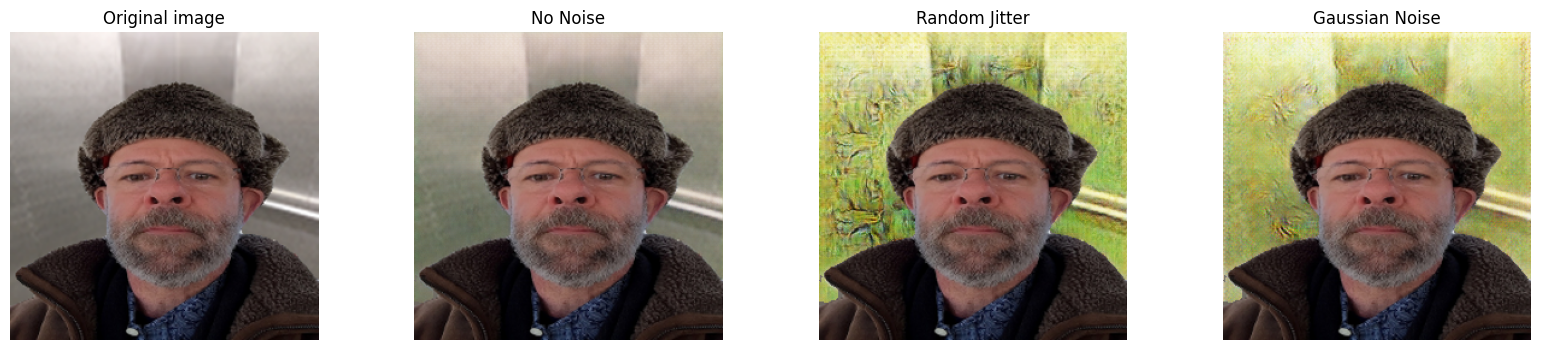

KeyboardInterrupt: ignored

In [31]:
from sklearn.model_selection import train_test_split

_, x_test, _, _ = train_test_split(image_files, mask_files, test_size=0.1, random_state=55)

for i in range(0, len(x_test)):
    file_path = x_test[i]
    original_image = load_image(file_path)

    segmented_image = image_segmentor([original_image.reshape(1,256,256,3)])
    segmented_image = np.array(segmented_image < 0.5, dtype=int).reshape(256, 256)
    bg_ind = np.where(segmented_image == 0)

    styled_image_no_noise = get_styled_image(original_image, "no_noise")
    styled_image_rj = get_styled_image(original_image, "random_jitter")
    styled_image_g = get_styled_image(original_image, "gaussian")

    styled_bg_no_noise = get_styled_bg(original_image, styled_image_no_noise, bg_ind)
    styled_bg_rj = get_styled_bg(original_image, styled_image_rj, bg_ind)
    styled_bg_g = get_styled_bg(original_image, styled_image_g, bg_ind)

    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
    for i in range(1):
        axs[0].set_title('Original image')
        axs[0].imshow(original_image)
        axs[0].axis("off")
        axs[1].set_title('No Noise')
        axs[1].imshow(styled_bg_no_noise)
        axs[1].axis("off")
        axs[2].set_title('Random Jitter')
        axs[2].imshow(styled_bg_rj)
        axs[2].axis("off")
        axs[3].set_title('Gaussian Noise')
        axs[3].imshow(styled_bg_g)
        axs[3].axis("off")

    plt.show()